In [1]:
"""
Sample from a trained model
"""
import os
import pickle
from contextlib import nullcontext
import torch
import tiktoken
from model import GPTConfig, GPT

# -----------------------------------------------------------------------------
init_from = 'resume' # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
out_dir = 'out' # ignored if init_from is not 'resume'
start = "0 5 0" # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
num_samples = 1 # number of samples to draw
max_new_tokens = 500 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 200 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cuda' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = False # use PyTorch 2.0 to compile the model to be faster
# -----------------------------------------------------------------------------
# Configuration for training GPT on maze navigation data
# Optimized for path learning task

# I/O
out_dir = 'out-maze-nav'
eval_interval = 250
log_interval = 10
eval_iters = 100
eval_only = False
always_save_checkpoint = True

# wandb logging
wandb_log = False
wandb_project = 'maze-nav'
wandb_run_name = 'maze-nav-gpt'

# data
dataset = 'maze/maze_nav_data'  # This should match your maze data directory
gradient_accumulation_steps = 1  # Reduced for smaller sequences
batch_size = 32  # Reasonable batch size for path learning
max_seq_len = 512  # Maximum sequence length for any path (no artificial limit)

# model - smaller model suitable for maze navigation
n_layer = 6   # Fewer layers for simpler task
n_head = 6    # Fewer attention heads
n_embd = 192  # Smaller embedding dimension
dropout = 0.1 # Some dropout for regularization
bias = False  # Cleaner model

# adamw optimizer
learning_rate = 3e-4  # Slightly higher learning rate
max_iters = 5000      # Fewer iterations needed
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.95
grad_clip = 1.0

# learning rate decay settings
decay_lr = True
warmup_iters = 100    # Quick warmup
lr_decay_iters = 5000 # Match max_iters
min_lr = 3e-5

# DDP settings
backend = 'nccl'

# system
device = 'cuda'
# Note: dtype check is done in train.py
dtype = 'bfloat16'  # will be validated in train.py
compile = False 


# -----------------------------------------------------------------------------

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# model
if init_from == 'resume':
    # init from a model saved in a specific directory
    ckpt_path = os.path.join(out_dir, 'ckpt.pt')
    checkpoint = torch.load(ckpt_path, map_location=device)
    gptconf = GPTConfig(**checkpoint['model_args'])
    model = GPT(gptconf)
    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict)
elif init_from.startswith('gpt2'):
    # init from a given GPT-2 model
    model = GPT.from_pretrained(init_from, dict(dropout=0.0))

model.eval()
model.to(device)
if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)

# look for the meta pickle in case it is available in the dataset folder
load_meta = False
if init_from == 'resume' and 'config' in checkpoint and 'dataset' in checkpoint['config']: # older checkpoints might not have these...
    meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
    load_meta = os.path.exists(meta_path)
if load_meta:
    print(f"Loading meta from {meta_path}...")
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    # Handle both string and integer tokens for maze navigation
    stoi, itos = meta['stoi'], meta['itos']
    
    def encode(s):
        if isinstance(s, str):
            if s.isdigit():
                # Handle numeric node IDs
                return [stoi[s]] if s in stoi else [int(s)]
            else:
                # Handle direction tokens or other strings
                tokens = s.split()
                return [stoi[token] if token in stoi else int(token) if token.isdigit() else stoi.get(token, 0) for token in tokens]
        elif isinstance(s, list):
            # Handle list of tokens
            return [stoi[str(token)] if str(token) in stoi else (int(token) if isinstance(token, str) and token.isdigit() else token) for token in s]
        else:
            return [stoi[str(s)] if str(s) in stoi else s]
    
    def decode(l):
        if 'direction_tokens' in meta:
            # Maze navigation specific decoding
            result = []
            for i in l:
                token = itos.get(i, str(i))
                result.append(token)
            return ' '.join(result)
        else:
            # Standard string concatenation
            return ''.join([itos.get(i, str(i)) for i in l])
else:
    # ok let's assume gpt-2 encodings by default
    print("No meta.pkl found, assuming GPT-2 encodings...")
    enc = tiktoken.get_encoding("gpt2")
    encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
    decode = lambda l: enc.decode(l)

# encode the beginning of the prompt
if start.startswith('FILE:'):
    with open(start[5:], 'r', encoding='utf-8') as f:
        start = f.read()

print(f"Starting with: {start}")
start_ids = encode(start)
print(f"Encoded as: {start_ids}")
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            generated_sequence = y[0].tolist()
            decoded_output = decode(generated_sequence)
            print(f"Sample {k+1}:")
            print(f"Raw tokens: {generated_sequence}")
            print(f"Decoded: {decoded_output}")
            print('---------------')


number of parameters: 2.67M
Loading meta from data/maze/maze_nav_data/meta.pkl...
Starting with: 0 5 0
Encoded as: [0, 5, 0]
Sample 1:
Raw tokens: [0, 5, 0, 101, 91, 101, 96, 102, 99, 102, 49, 100, 38, 103, 26, 101, 41, 102, 61, 100, 6, 101, 67, 101, 94, 103, 66, 100, 6, 103, 85, 103, 23, 100, 55, 102, 94, 101, 43, 100, 49, 102, 94, 102, 43, 103, 33, 103, 43, 102, 39, 101, 19, 100, 27, 100, 9, 102, 48, 103, 19, 101, 12, 103, 24, 102, 39, 100, 46, 100, 18, 102, 34, 103, 19, 101, 29, 80, 100, 26, 101, 61, 55, 103, 28, 101, 62, 103, 8, 101, 67, 103, 18, 101, 42, 102, 50, 102, 18, 100, 39, 101, 6, 101, 12, 61, 103, 79, 102, 70, 103, 13, 102, 89, 103, 44, 102, 89, 103, 39, 103, 59, 102, 64, 103, 68, 102, 79, 102, 102, 97, 103, 103, 4, 103, 18, 102, 58, 2, 44, 102, 47, 102, 21, 100, 55, 100, 2, 102, 13, 101, 92, 103, 11, 100, 42, 102, 50, 102, 38, 6, 59, 43, 45, 1, 47, 56, 86, 43, 7, 12, 103, 52, 100, 41, 102, 11, 103, 50, 101, 65, 72, 20, 100, 19, 78, 38, 56, 102, 19, 100, 17, 102, 31, 103,

In [2]:
# To use the logit lens we have to define tokenizer

class MazeNavTokenizer:
    def __init__(self, encode, decode):
        self.encode = lambda x: torch.tensor(encode(x))
        self.decode = lambda x: decode(x)

tokenizer = MazeNavTokenizer(encode, decode)

In [3]:
# Test if the model structure is compatible with transformer_utils
print("Model structure:")
print("model.base_model:", type(model.base_model))
print("model.base_model.h:", type(model.base_model.h))

# Check what modules the library can find
print("\nAll modules in base_model:")
for name, module in model.base_model.named_modules():
    if 'norm' in name.lower() or 'ln' in name.lower():
        print(f"  {name}: {type(module)}")

# Let's also check the model structure more deeply        
print("\nDirect access tests:")
print("hasattr(model.base_model, 'ln_f'):", hasattr(model.base_model, 'ln_f'))
print("hasattr(model.base_model, 'final_layernorm'):", hasattr(model.base_model, 'final_layernorm'))

if hasattr(model.base_model, 'ln_f'):
    print("model.base_model.ln_f:", type(model.base_model.ln_f))
if hasattr(model.base_model, 'final_layernorm'):
    print("model.base_model.final_layernorm:", type(model.base_model.final_layernorm))
print("model.lm_head:", type(model.lm_head))

Model structure:
model.base_model: <class 'torch.nn.modules.container.ModuleDict'>
model.base_model.h: <class 'torch.nn.modules.container.ModuleList'>

All modules in base_model:
  h.0.ln_1: <class 'torch.nn.modules.normalization.LayerNorm'>
  h.0.ln_2: <class 'torch.nn.modules.normalization.LayerNorm'>
  h.1.ln_1: <class 'torch.nn.modules.normalization.LayerNorm'>
  h.1.ln_2: <class 'torch.nn.modules.normalization.LayerNorm'>
  h.2.ln_1: <class 'torch.nn.modules.normalization.LayerNorm'>
  h.2.ln_2: <class 'torch.nn.modules.normalization.LayerNorm'>
  h.3.ln_1: <class 'torch.nn.modules.normalization.LayerNorm'>
  h.3.ln_2: <class 'torch.nn.modules.normalization.LayerNorm'>
  h.4.ln_1: <class 'torch.nn.modules.normalization.LayerNorm'>
  h.4.ln_2: <class 'torch.nn.modules.normalization.LayerNorm'>
  h.5.ln_1: <class 'torch.nn.modules.normalization.LayerNorm'>
  h.5.ln_2: <class 'torch.nn.modules.normalization.LayerNorm'>
  ln_f: <class 'torch.nn.modules.normalization.LayerNorm'>

Direc

In [4]:
from transformer_utils.logit_lens import plot_logit_lens
from transformer_utils.partial_forward import partial_forward

/home/xh/miniconda3/envs/general/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
start = "0 11 0"
start_ids = tokenizer.encode(start)
print(start_ids)
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
y = model.generate(x, max_new_tokens=100, temperature=1, top_k=1)
print(tokenizer.decode(y[0].tolist()))

tensor([ 0, 11,  0])
0 11 0 right 94 down 94 down 94 down 84 down 84 down 72 down 94 down 94 down 94 down 94 down 94 down 94 down 94 down 94 up 94 up 94 down 54 down 44 down 43 down 33 up 34 up 15 up 15 up 94 up 94 down 94 down 24 down 25 down 54 down 54 down 54 down 63 down 63 down 84 right 84 down 94 up 94 right 94 up 94 up 19 left 94 left 8 up 8 left 7 left 5 up 3 up 13 up 12 down 12 down 12


/tmp/ipykernel_599021/3923280279.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])


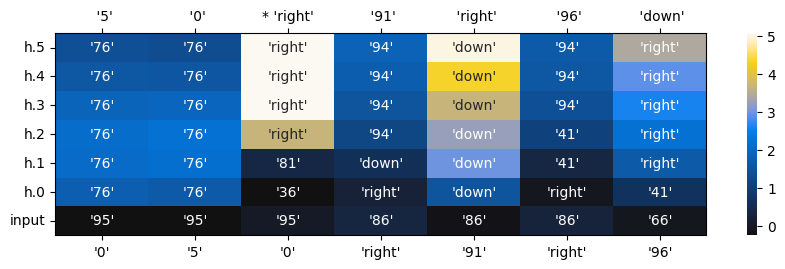

In [6]:
input_ids = tokenizer.encode("0 5 0").unsqueeze(0).to(device)
input_ids = torch.tensor([0, 5, 0, 101, 91, 101, 96, 102]).unsqueeze(0).to(device)
plot_logit_lens(model, tokenizer, input_ids, start_ix=0, end_ix=7)

In [11]:
import ecco

# You would need to provide a config for your model to ecco
# For now, we can try to initialize ecco's LM
# Note: You'll likely need to create a custom model-config.yaml entry
# for your model to specify activation layers correctly.
lm = ecco.LM(
    model=model,
    tokenizer=tokenizer,
    model_name='my-gpt', # A custom name
    config={ # A minimal config for ecco
        'model_name': 'my-gpt',
        'type': 'causal',
        'embedding': 'transformer.wte', # Path to embedding layer
        'activations': [".*mlp.c_fc"], # Regex to find activation layers
        'tokenizer_config': {}
    }
)

output = lm.generate("Hello, my name is", generate=5)

AttributeError: 'GPTConfig' object has no attribute 'top_k'